In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 700)

This notebook calculates accumulated degree days (ADD) per image. Will begin with a temp. threshold of 0 deg. C.
E.g. Given a donor who has been dead for 4 days with avg. daily temps. of 4, -1, 3, and 4, the ADD = 4+3+4 = 11 deg. C.

Note:
- Temp. values are in degree Celcius.
- Hum. values, relative humidity, are expressed as a percent that represents the amount of water vapor in the air at a given temperature compared to the max possible water vapor amount at that same temperature. For instance, relative humidity of 25 percent means that air is at a quarter of its possible water vapor capacity.

# Import PMI labeled data

In [ ]:
# import SOD-labeled data
df_pmi_sod = pd.read_csv('../data/img_PMIs_no_negs.csv')[['path', 'label', 'old_date', 'date_placed_ARF', 'img_pmi_days']]
display(df_pmi_sod.head())
print(df_pmi_sod.shape)

In [ ]:
# convert dtypes
df_pmi_sod['old_date'] = pd.to_datetime(df_pmi_sod['old_date'], format='%Y-%m-%d', errors='coerce')
df_pmi_sod['date_placed_ARF'] = pd.to_datetime(df_pmi_sod['date_placed_ARF'], format='%Y-%m-%d', errors='coerce')
df_pmi_sod.info()

# Import tinytag temp/hum data

In [ ]:
df_tinyt = pd.read_csv('/data/anau/temp_humidity_data/data/all_temp_hum_processed').sort_values(['date', 'time'])
display(df_tinyt.head())
print(df_tinyt.shape)
display(df_tinyt.info())

In [ ]:
# convert dtypes
df_tinyt['date'] = pd.to_datetime(df_tinyt['date'], format='%Y-%m-%d', errors='coerce')
df_tinyt.info()

In [ ]:
# groupby date to calulate daily avg. temp/hum
df_tinyt_daily_avg = df_tinyt.groupby('date')[['temp_C', 'hum_RH']].mean().reset_index()
display(df_tinyt_daily_avg.head())
print(df_tinyt_daily_avg.shape)
print(df_tinyt_daily_avg.date.nunique())
display(df_tinyt_daily_avg.describe(datetime_is_numeric=True))
df_tinyt_daily_avg.info()

In [ ]:
# check time range of data to see what missing and will need to be filled
print(df_tinyt_daily_avg.date.dt.year.unique())

print('2014:', df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2014].date.dt.month.unique())
print('2015:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2015].date.dt.month.unique())
print('2016:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2016].date.dt.month.unique())
print('2017:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2017].date.dt.month.unique())
print('2019:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2019].date.dt.month.unique())
print('2020:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2020].date.dt.month.unique())
print('2021:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2021].date.dt.month.unique())

In [ ]:
# add source column
df_tinyt_daily_avg['source'] = 'tinytag'
display(df_tinyt_daily_avg.head())
df_tinyt_daily_avg.shape

# Import LCD daily avg. temp/hum data to fill in the gaps
This data has been preprocessed in ../temp_humidity_data/.

In [ ]:
df_lcd_daily_avg = pd.read_pickle('../temp_humidity_data/data/LCD/lcd_daily_avg.pkl')
display(df_lcd_daily_avg.head())
display(df_lcd_daily_avg.info())
df_lcd_daily_avg.shape

In [ ]:
# add source column
df_lcd_daily_avg['source'] = 'lcd'
display(df_lcd_daily_avg.head())

# Merge Tinytag and LCD data
Fill in gaps of Tinytag temp/hum data with LCD temp/hum data

In [ ]:
print(df_tinyt_daily_avg.dtypes)
print(df_lcd_daily_avg.dtypes)

In [ ]:
# outer join on date column
df_temp_hum_merged = pd.merge(df_tinyt_daily_avg, df_lcd_daily_avg, on='date', how='outer')
print(df_temp_hum_merged.shape)
df_temp_hum_merged.sort_values('date', inplace=True)
display(df_temp_hum_merged.head())

In [ ]:
# create final temp and hum columns
df_temp_hum_merged["final_temp"] = np.where(df_temp_hum_merged["temp_C"].isnull(), 
                            df_temp_hum_merged['HourlyDryBulbTemperature'], df_temp_hum_merged["temp_C"])
df_temp_hum_merged["final_hum"] = np.where(df_temp_hum_merged["hum_RH"].isnull(), 
                            df_temp_hum_merged['HourlyRelativeHumidity'], df_temp_hum_merged["hum_RH"])
df_temp_hum_merged["final_source"] = np.where(df_temp_hum_merged["source_x"].isnull(), 
                            df_temp_hum_merged['source_y'], df_temp_hum_merged["source_x"])
display(df_temp_hum_merged.head())
display(df_temp_hum_merged.info())
display(df_temp_hum_merged.describe(datetime_is_numeric=True))

In [ ]:
# check time range of data make sure no gaps
print(df_temp_hum_merged.date.dt.year.unique())

print('2014:', df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2014].date.dt.month.unique())
print('2015:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2015].date.dt.month.unique())
print('2016:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2016].date.dt.month.unique())
print('2017:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2017].date.dt.month.unique())
print('2019:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2019].date.dt.month.unique())
print('2020:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2020].date.dt.month.unique())
print('2021:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2021].date.dt.month.unique())

In [ ]:
ax = plt.gca() 
df_temp_hum_merged.plot( x = 'date' , y = 'final_temp', ax = ax)

# Calculate ADD

In [ ]:
df_dict = df_pmi_sod.to_dict('records')
for row in df_dict:
    placement_date = row['date_placed_ARF']
    img_date = row['old_date']
    
    add = 0
    start_date = placement_date
    while (start_date <= img_date):
        temp = df_temp_hum_merged[df_temp_hum_merged.date == start_date]['final_temp'].values[0]
        if temp < 0:
            temp = 0
        
        add += temp
        start_date += datetime.timedelta(days=1)
        print('date:'+str(start_date)+', temp:'+str(temp)+ ', add:'+str(add),  end="\n")
    row['add'] = add
    print()

In [ ]:
df_pmi_sod_add = pd.DataFrame.from_dict(df_dict)

In [3]:
df_pmi_sod_add = pd.read_pickle('../data/head/df_pmi_sod_add')
display(df_pmi_sod_add.head())
print(df_pmi_sod_add.shape)

,path,label,old_date,date_placed_ARF,img_pmi_days,add
0,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.08.JPG,2,2018-01-22,2018-01-21,1.0,18.969456
1,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000129.14.JPG,2,2018-01-29,2018-01-21,8.0,64.144508
2,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000213.21.JPG,2,2018-02-13,2018-01-21,23.0,133.226682
3,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000219.07.JPG,3,2018-02-19,2018-01-21,29.0,210.208472
4,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000222.08.JPG,3,2018-02-22,2018-01-21,32.0,271.839059


(3417, 6)


In [4]:
df_pmi_sod_add.describe()

,label,img_pmi_days,add
count,3417.000000,3417.000000,3417.000000
mean,2.544337,40.611062,572.157320
std,1.009256,54.210218,826.716138
min,1.000000,0.000000,0.000000
25%,2.000000,10.000000,130.768497
50%,2.000000,27.000000,364.404999
75%,3.000000,54.000000,683.799106
max,4.000000,802.000000,12268.918347


# Correlation between SOD and ADD

In [4]:
# correlation using all quartiles
df_pmi_sod_add['label'].corr(np.log10(df_pmi_sod_add['add']+1*(10**-4)))

0.632152657867109

In [5]:
# split data by SOD
df_add_one = df_pmi_sod_add[df_pmi_sod_add.label == 1]
print(df_add_one.shape)
df_add_two = df_pmi_sod_add[df_pmi_sod_add.label == 2]
print(df_add_two.shape)
df_add_three = df_pmi_sod_add[df_pmi_sod_add.label == 3]
print(df_add_three.shape)
df_add_four = df_pmi_sod_add[df_pmi_sod_add.label == 4]
print(df_add_four.shape)
print()
# keep only 1-3 quartiles 
df_add_one = df_add_one[df_add_one.img_pmi_days <=3].copy()
print(df_add_one.shape)
df_add_two = df_add_two[df_add_two.img_pmi_days <=57].copy()
print(df_add_two.shape)
df_add_three = df_add_three[df_add_three.img_pmi_days <=58].copy()
print(df_add_three.shape)
df_add_four = df_add_four[df_add_four.img_pmi_days <= 67].copy()
print(df_add_four.shape)
print()
# concat into one df
df_add_sod_filtered = pd.concat([df_add_one, df_add_two, df_add_three, df_add_four])
print(df_add_sod_filtered.shape)

(518, 6)
(1319, 6)
(782, 6)
(798, 6)

(397, 6)
(997, 6)
(589, 6)
(598, 6)

(2581, 6)


In [6]:
# correlation using 1-3 quartiles
df_add_sod_filtered['label'].corr(np.log10(df_add_sod_filtered['add']+1*(10**-4)))

0.6835916665491608

<AxesSubplot: xlabel='add', ylabel='label'>

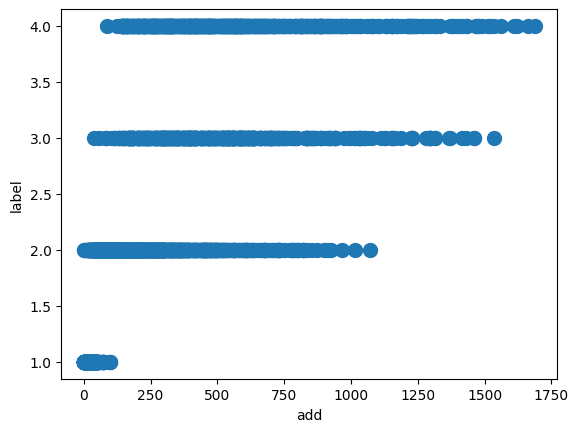

In [7]:
df_add_sod_filtered.plot.scatter(x = 'add', y = 'label', s = 100)